# Recuperação da Informação e Busca na Web - 2018.1

### Atividade: Projeto Final - Agrupamento de Notícias
### Aluno: Johanny de Lucena Santos

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

## Importação das bibliotecas necessárias
Aqui, iremos usar a biblioteca pandas, para tratar o DataFrame, nltk, para as stopwords, matplotlib, para plotagem dos gráficos juntamente com wordcloud, e por fim, a biblioteca sklearn, responsável por gerar os grupos de palavras.

In [5]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords

import re

import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn import feature_extraction
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.externals import joblib

from wordcloud import WordCloud, STOPWORDS #pip install wordcloud

In [3]:
#nltk.download('punkt')
#nltk.download('corpus')

## Importando a base de dados necessária para o agrupamento de notícias
Aqui, é feita a importação do arquivo csv para a análise. Em seguida, substituo as linhas com NaN por um espaço em branco. E por fim, um array é criado, onde cada índice possui o título, subtítulo e conteúdo da notícia.

In [6]:
dataset = pd.read_csv('../data/estadao_noticias_eleicao.csv', encoding="utf-8")
dataset = dataset.replace(np.nan, '', regex=True)
documentos = dataset.titulo + " " + dataset.subTitulo + " " + dataset.conteudo

titulos = dataset.titulo
subtitulos = dataset.subTitulo
conteudo = dataset.conteudo

## Informações do dataset

In [7]:
print("%d notícias" % len(dataset))

8716 notícias


## Definindo número de clusters
Aqui, iremos calcular o número ideal de clusters para agrupar nossas notícias, baseado no número de colunas que nosso dataset possui.

In [8]:
labels  = dataset.columns
true_k = np.unique(labels).shape[0]

## Definindo o stopwords

In [9]:
stopwords = nltk.corpus.stopwords.words('portuguese')
print (stopwords[:10])

['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para']


## Função para gerar o wordcloud de cada cluster

In [10]:
def generate_wordcloud(text):
    wordcloud = WordCloud(background_color='black',
                          width=1600,
                          height= 800,
                          min_font_size=10,
                          font_path='./data/NotoSansDisplay-Regular.ttf',
                          relative_scaling = 1.0,
                          stopwords = nltk.corpus.stopwords.words('portuguese')
                          ).generate(text)
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

## Calculando TF-IDF
Através da biblioteca sklearn, calculamos o TF-IDF de cada palavra no documento que possui o conjunto de notícias

In [11]:
vectorizer = TfidfVectorizer(stop_words=stopwords,analyzer='word',ngram_range=(1, 1), lowercase=True, use_idf=True)
X = vectorizer.fit_transform(documentos)

## Utilizando o algoritmo K-Means
Aqui, usamos o algoritmo K-Means para gerar nosso modelo.

In [12]:
model = KMeans(n_clusters=true_k, init='k-means++',max_iter=1000, n_init=1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=6, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

## Gerando o word cloud dos clusters

#### Para cada conjunto de palavras dos clusters, a que mais se repete é a que vai ter um tamanho de fonte maior




Cluster 1:


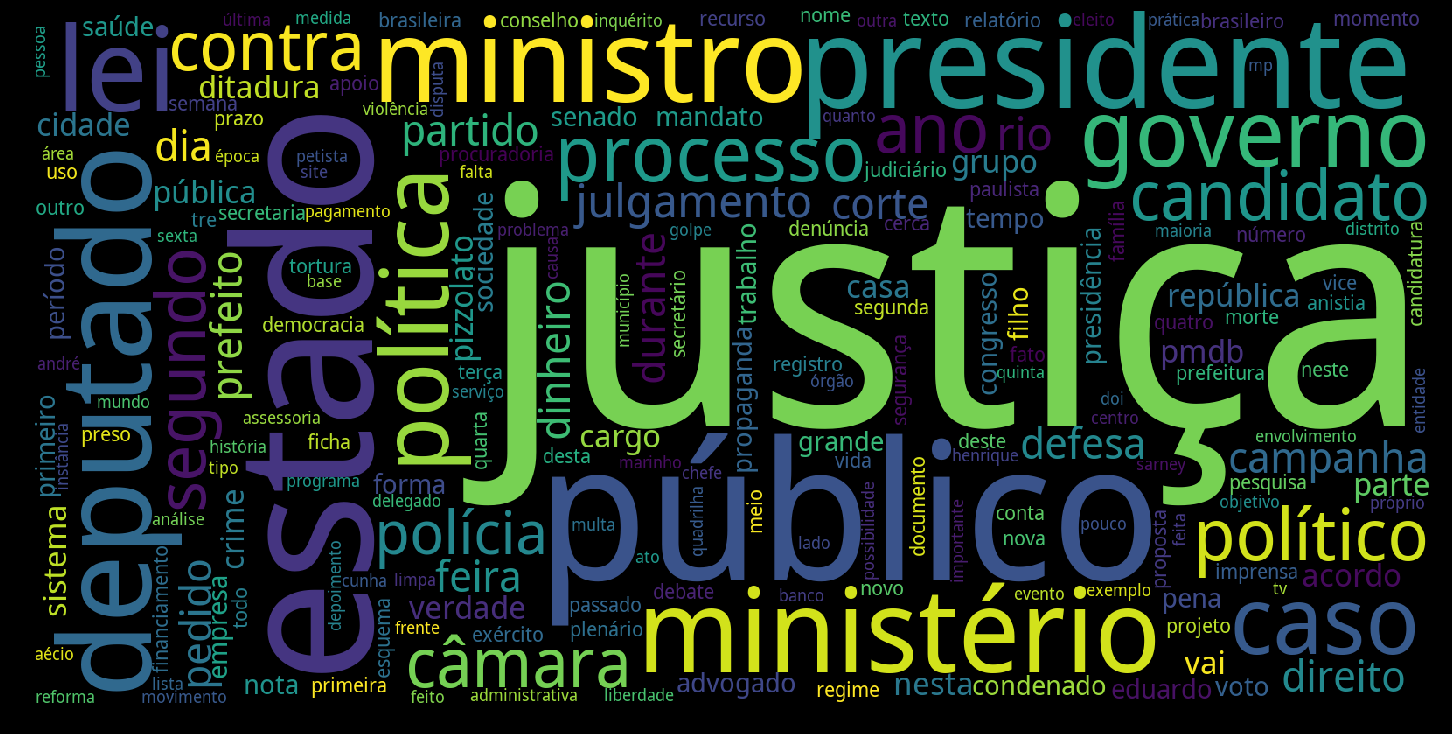



Cluster 2:


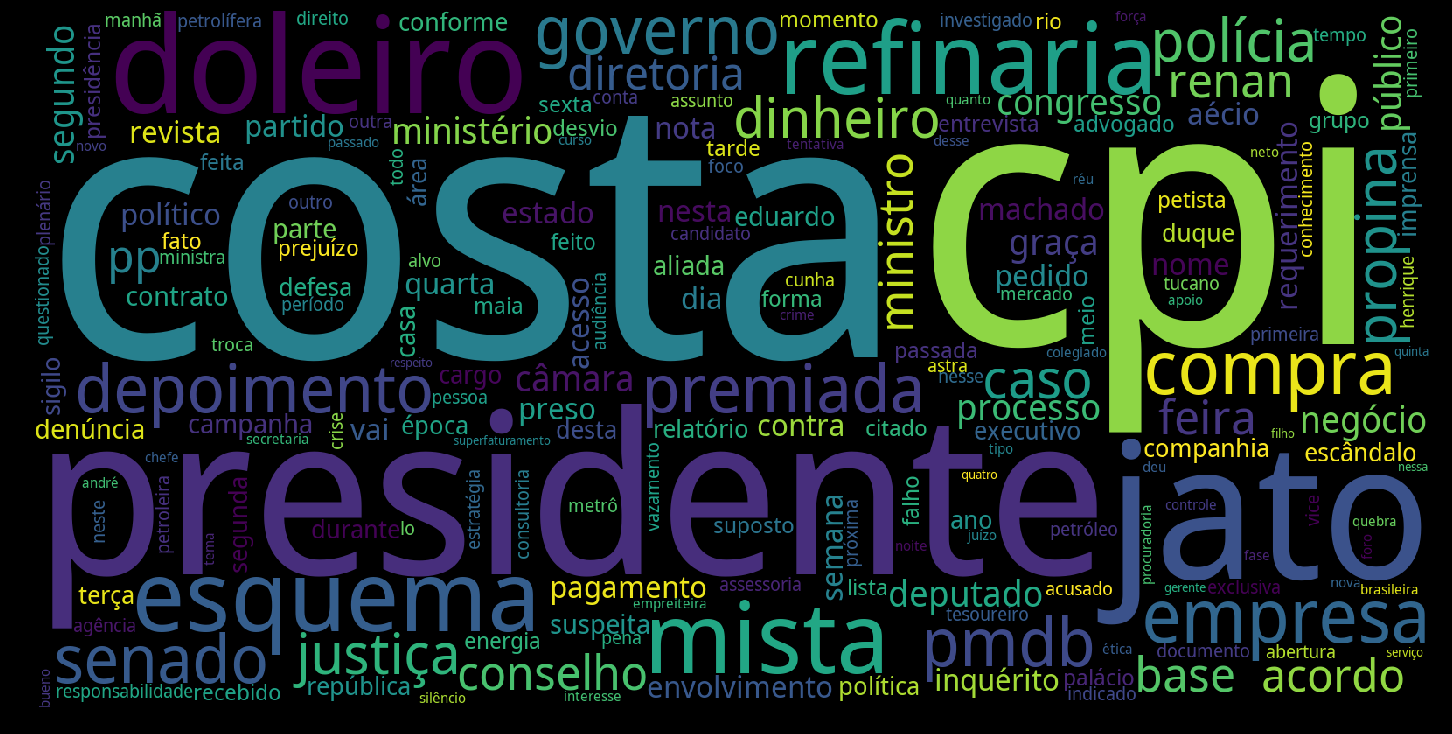



Cluster 3:


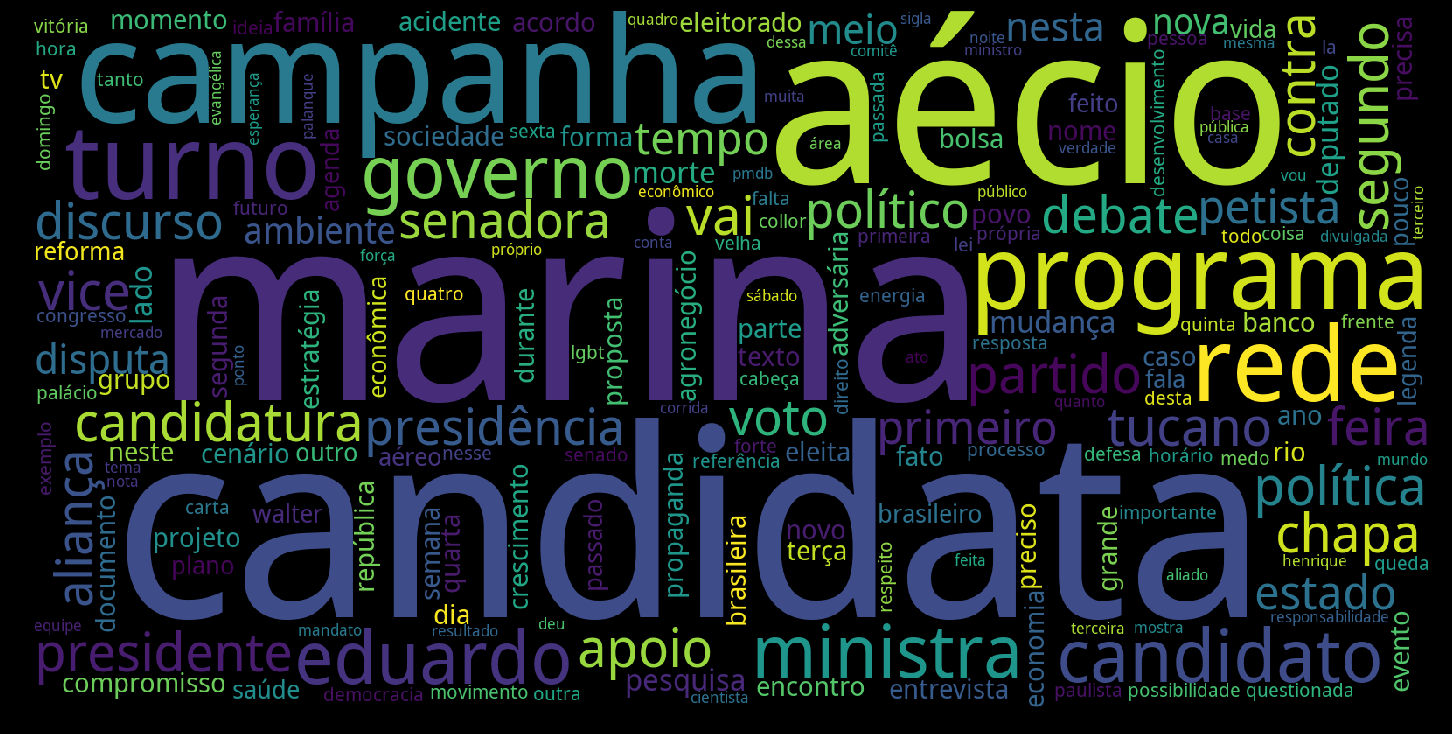



Cluster 4:


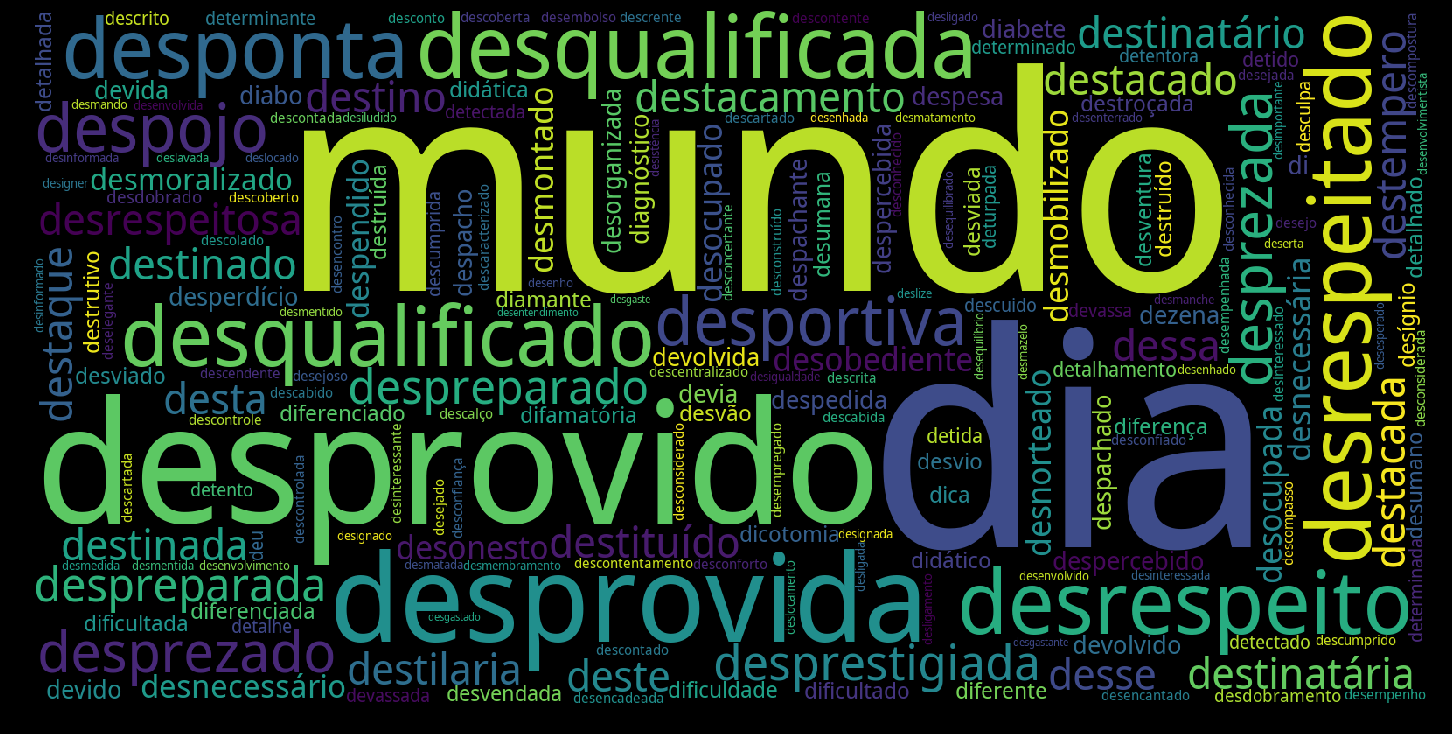



Cluster 5:


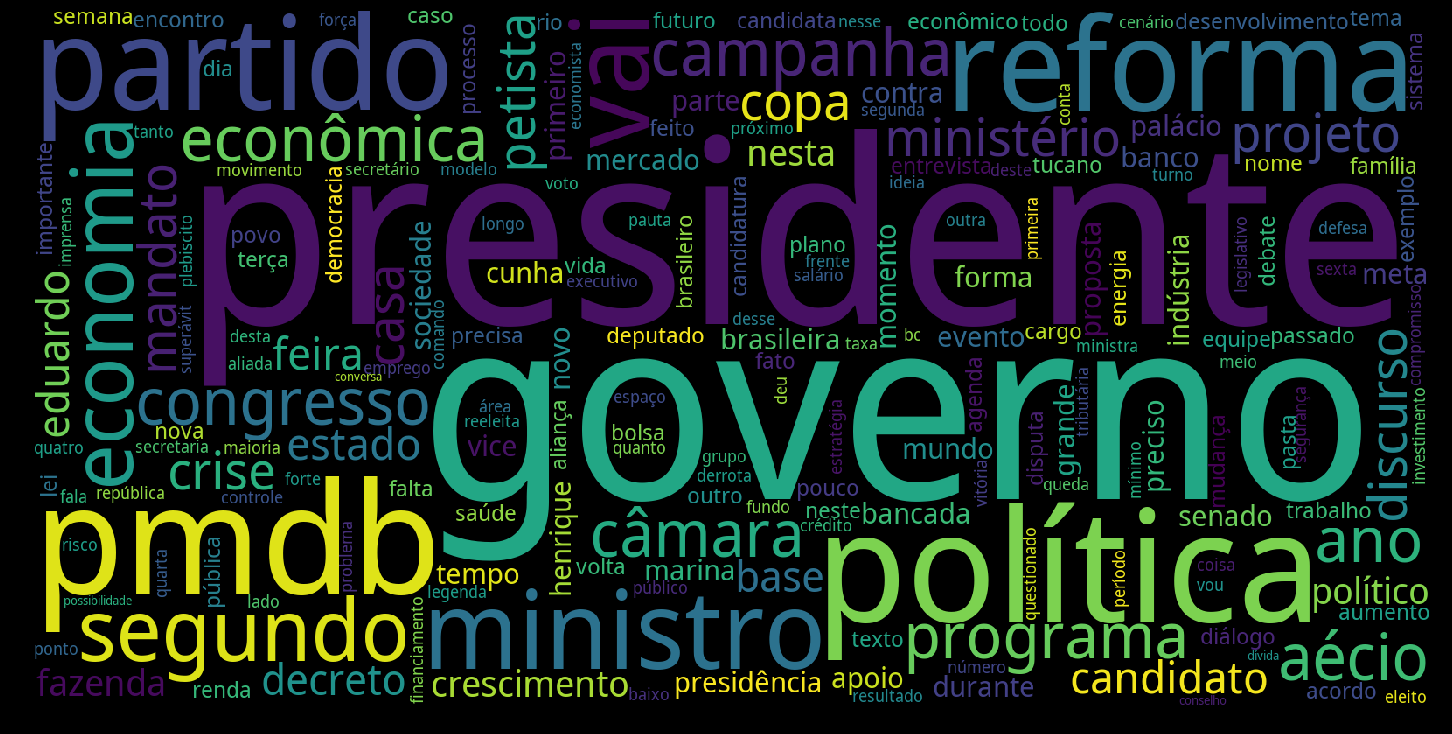



Cluster 6:


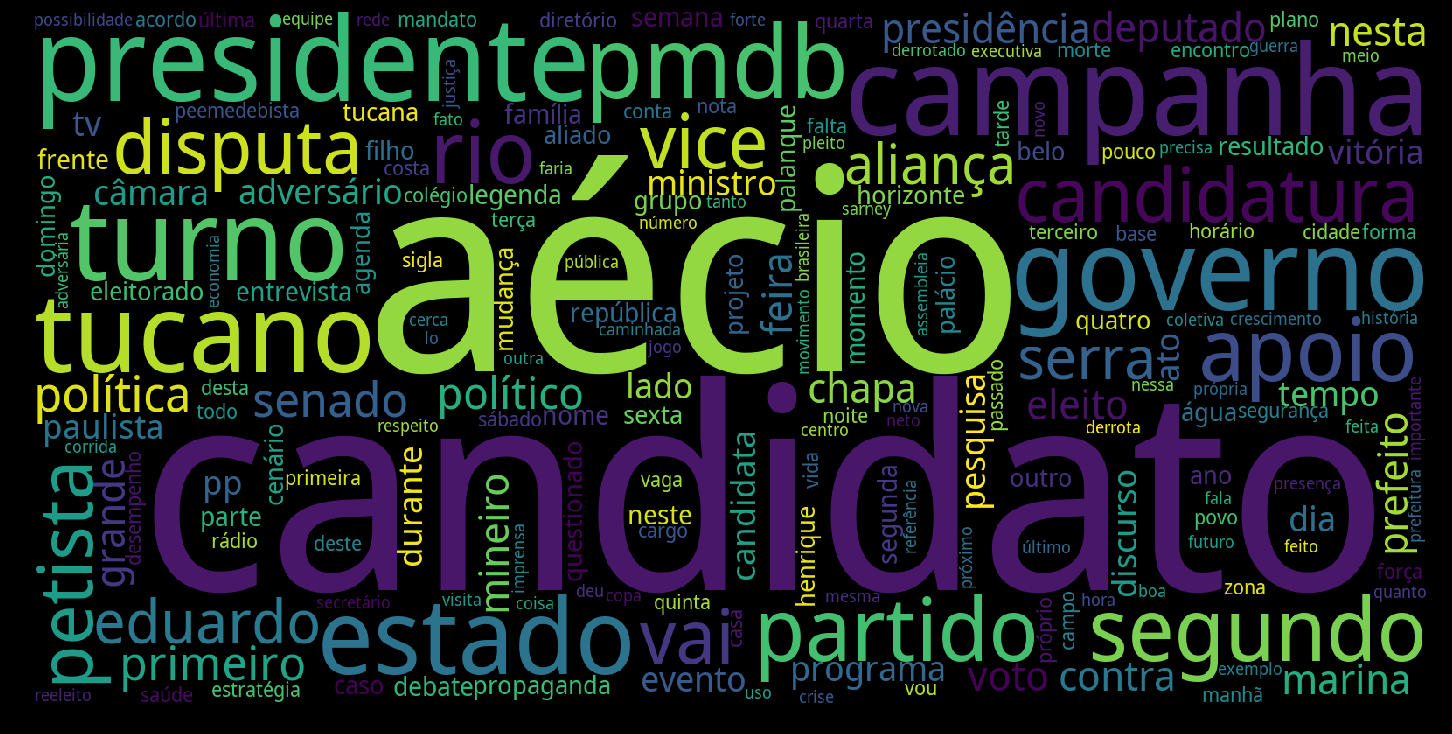

In [13]:
order_centroids = model.cluster_centers_.argsort()[:,::-1]
terms = vectorizer.get_feature_names()

print("\n")

for i in range(true_k):
    text = ""
    print("\nCluster %d:" % (i+1), end='')
    #for ind in order_centroids[i, :20]:
    for ind in order_centroids[i]:
        #print(' %s;' % terms[ind], end='')
        text += terms[ind] + " "
        
    print()
    generate_wordcloud(text)
    print()
    
print("\n")